# Detection of coronary artery tree using morphological Operator
## S Eiho, Y Qian

### Structuring Elements

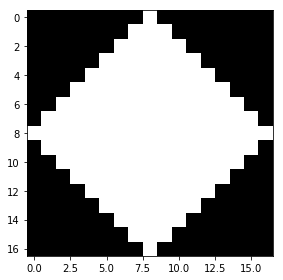

In [37]:
import numpy as np
from skimage import io
from numba import jit
from skimage import img_as_ubyte
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

@jit(nopython = True)
def getDiamondSE(size):
    elem = np.zeros((size, size), dtype=np.uint8)
    if size % 2 == 0 : 
        print('invalid size')
        return elem
    mid = int(size / 2)
    for i in range(size):
        elem[i, mid] = 255
        if i < size-mid:
            for j in range(i):
                elem[i, mid - (j + 1)] = 255
                elem[i, mid + (j +1 )] = 255
        else:
            for j in range(size - i-1):
                elem[i, mid - (j + 1)] = 255
                elem[i, mid + (j + 1)] = 255
    return elem

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    io.imshow(getDiamondSE(17))
    io.show()

### Morphological Operators
#### Dilatation

In [96]:
@jit(nopython = True)
def dilatation(img, selem):
    img2 = np.zeros_like(img)
    def maxVal(i, j):
        sz = int(selem.shape[0]/2)
        min_i, max_i = i - sz, i + sz
        min_j, max_j = j - sz, j + sz
        if min_i < 0 : min_i = 0
        if min_j < 0 : min_j = 0
        if max_i > img.shape[0] : max_i = img.shape[0]
        if max_j > img.shape[1] : max_j = img.shape[1]
        max_v = img[i,j]
        for y in range(min_i, max_i):
            for x in range(min_j, max_j):
                if img[y,x] < max_v : max_v = img[y,x]
        return max_v
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img2[i, j] = maxVal(i,j)
    return img2

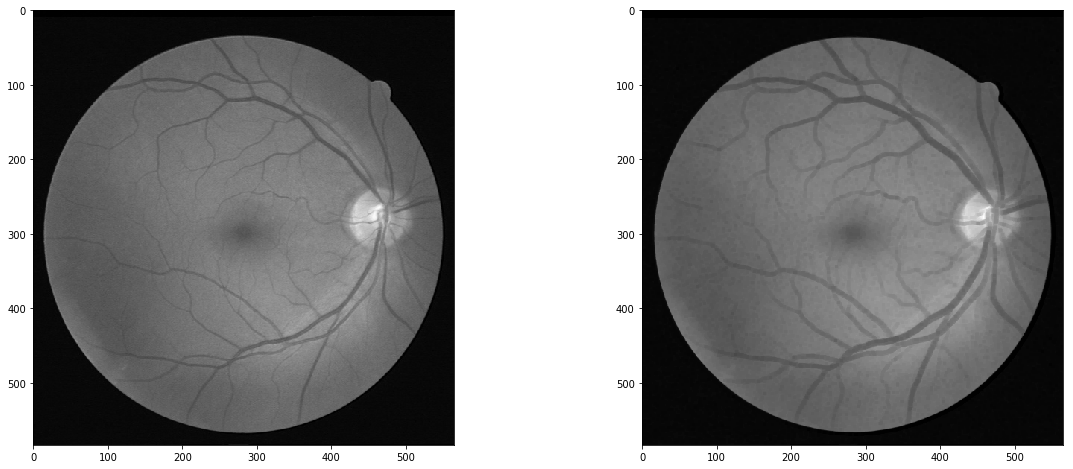

In [97]:
# %%time
import warnings
filename = './DRIVE/10 test.tif'
# with warnings.catch_warnings():
# warnings.simplefilter("ignore")
img = img_as_ubyte(rgb2gray(io.imread(filename)))
img2 = dilatation(img, getDiamondSE(5))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

#### Erosion

In [106]:
@jit(nopython = True)
def erosion(img, selem):
    img2 = np.zeros_like(img)
    def minVal(i, j):
        sz = int(selem.shape[0]/2)
        min_i, max_i = i - sz, i + sz
        min_j, max_j = j - sz, j + sz
        if min_i < 0 : min_i = 0
        if min_j < 0 : min_j = 0
        if max_i > img.shape[0] : max_i = img.shape[0]
        if max_j > img.shape[1] : max_j = img.shape[1]
        max_v = img[i,j]
        for y in range(min_i, max_i):
            for x in range(min_j, max_j):
                if img[y,x] > max_v : max_v = img[y,x]
        return max_v
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img2[i, j] = minVal(i,j)
    return img2

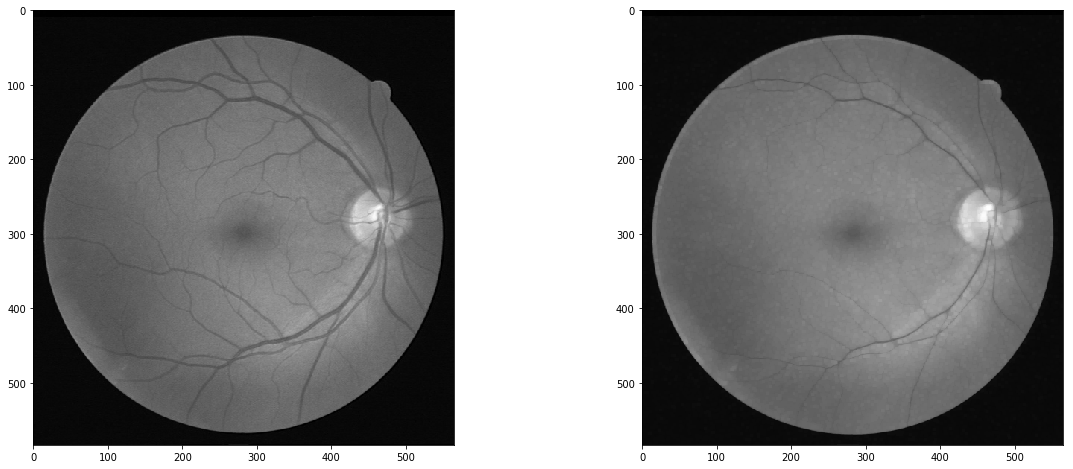

In [107]:
filename = './DRIVE/10 test.tif'
img = img_as_ubyte(rgb2gray(io.imread(filename)))
img2 = erosion(img, getDiamondSE(5))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

#### Opening

In [142]:
@jit(nopython = True)
def opening(img, selem):
    img2 = erosion(img, selem)
    return dilatation(img2, selem)

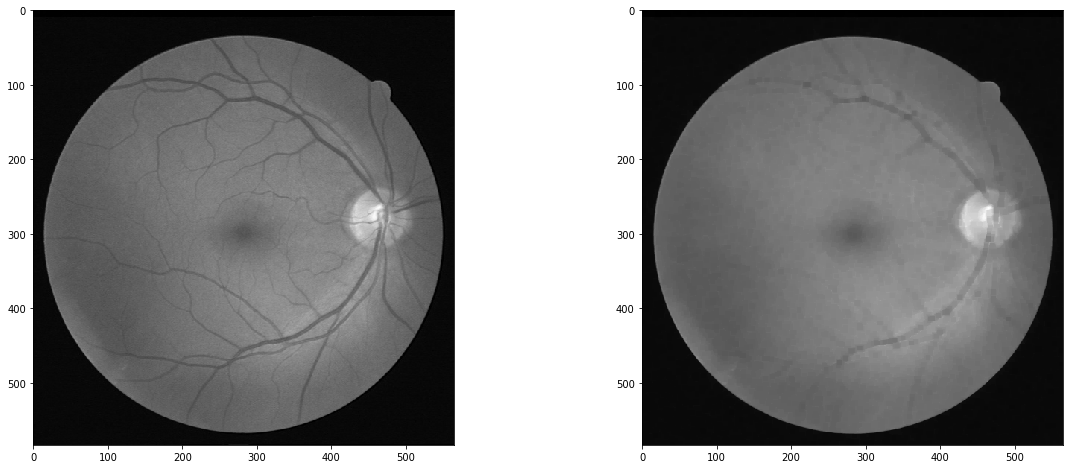

CPU times: user 453 ms, sys: 0 ns, total: 453 ms
Wall time: 454 ms


In [143]:
%%time
img2 = opening(img, getDiamondSE(7))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

#### Closing

In [145]:
@jit(nopython = True)
def closing(img, selem):
    img2 = dilatation(img, selem)
    return erosion(img2, selem)

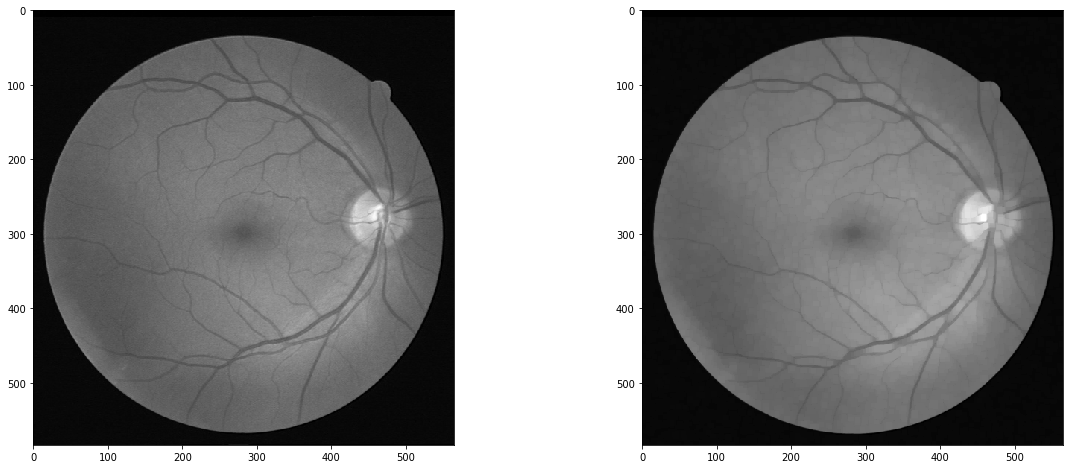

CPU times: user 449 ms, sys: 0 ns, total: 449 ms
Wall time: 449 ms


In [146]:
%%time
img2 = closing(img, getDiamondSE(7))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

#### TopHat

In [193]:
# @jit(nopython = True)
def topHat(img, selem):
    img2 = opening(img, selem)
    for i in range(img.shape[0]) :
        for j in range(img.shape[1]) :
            v = int(img[i,j]) - int(img2[i,j])
            if v < 0 : v = 0
            img2[i,j] = v
    return img2

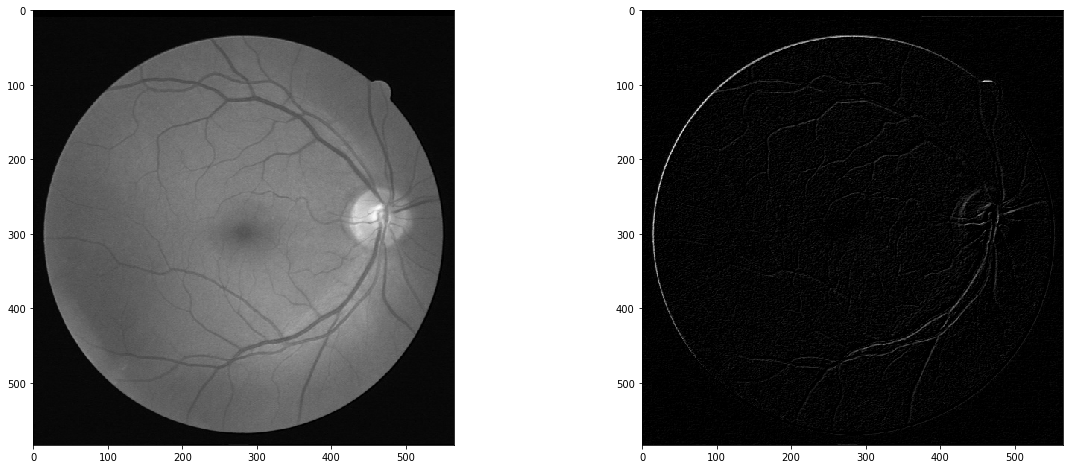

In [194]:
# %%time
img2 = topHat(img, getDiamondSE(3))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()